In [3]:
from control.matlab import tf
import numpy as np
import matplotlib.pyplot as plt

"""
後で使う関数の定義
"""

def linestyle_generator():
    """グラフをプロットするときの線種を決めるジェネレータ"""
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

def plot_set(fig_ax, *args):
    """グラフを整える"""
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':')
    if len(args) == 3:
        fig_ax.legend(loc=args[2])

def bodeplot_set(fig_ax, *args):
    """ボード線図を整える"""
    # ゲイン線図
    fig_ax[0].grid(which="both", ls=':')
    fig_ax[0].set_ylabel('Gain [dB]')

    # 位相線図
    fig_ax[1].grid(which="both", ls=':')
    fig_ax[1].set_xlabel('omega [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')

    # 凡例
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

"""
垂直駆動アームのモデル
"""

g = 9.81
l = 0.2
M = 0.5
mu = 1.5e-2
J = 1.0e-2

P = tf([0, 1], [J, mu, M*g*l])

ref = 30 # 目標角度

In [4]:
from control.matlab import ss, acker

A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = [[1, 0], [0, 1]]
D = [[0], [0]]
P = ss(A, B, C, D)

regular_poles = [-1, -1]
F = - acker(P.A, P.B, regular_poles)
print(F)

[[ 3. -7.]]


In [5]:
import numpy as np
print(np.linalg.eigvals(P.A + P.B @ F))

[-1. -1.]


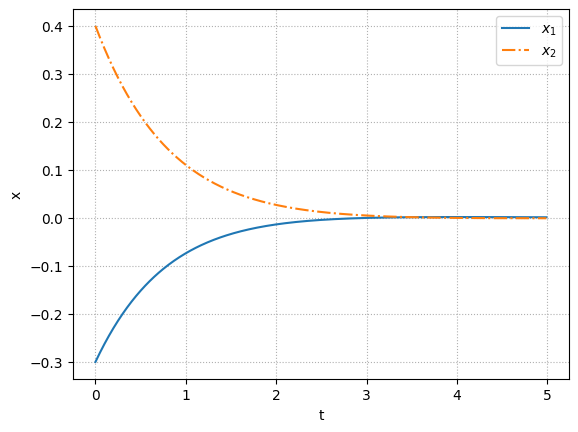

In [6]:
from control.matlab import ss, initial
import matplotlib.pyplot as plt

Acl = P.A + P.B @ F
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 5, 0.01)
X0 = [-0.3, 0.4]
x, t = initial(Pfb, Td, X0)

fig, ax = plt.subplots()
ax.plot(t, x[:, 0], label='$x_1$')
ax.plot(t, x[:, 1], label='$x_2$', ls='-.')
plot_set(ax, 't', 'x', 'best')

In [7]:
from control.matlab import lqr, care
import numpy as np

Q = np.diag([100, 1])
R = 1

F, X, E = lqr(P.A, P.B, Q, R)
F = -F

print("-------- フィードバックゲイン ---------")
print(F)
print(- (1/R) * P.B.T @ X)
print("-------- 閉ループ極 ---------")
print(E)
print(np.linalg.eigvals(P.A + P.B @ F))


-------- フィードバックゲイン ---------
[[ -6.77032961 -11.28813639]]
[[ -6.77032961 -11.28813639]]
-------- 閉ループ極 ---------
[-3.14406819+0.94083198j -3.14406819-0.94083198j]
[-3.14406819+0.94083198j -3.14406819-0.94083198j]


In [10]:
H = np.block([ [P.A, - P.B * (1/R) @ P.B.T], [-Q, - P.A.T] ])
eigH = np.linalg.eigvals(H)
print(eigH)

print("-------- ハミルトン行列の安定固有値 ---------")
eigH_stable = [ i for i in eigH if i < 0]
print(eigH_stable)

F = - acker(P.A, P.B, eigH_stable)
print(F)

[-3.14406819+0.94083198j -3.14406819-0.94083198j  3.14406819+0.94083198j
  3.14406819-0.94083198j]
-------- ハミルトン行列の安定固有値 ---------
[np.complex128(-3.1440681937792796+0.9408319760374402j), np.complex128(-3.1440681937792796-0.9408319760374402j)]
[[ -6.77032961 -11.28813639]]
